# Ex18 문자를 읽을 수 있는 딥러닝

* 프로젝트 목적: OCR을 활용하여 이미지 안의 글씨를 인식하자
* 사용모델: keras ocr. google ocr, 테서렉트 ocr

## 1. 라이브러리 세팅 및 이미지 가져오기

In [1]:
import os
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

# keras_ocr
import keras_ocr

# 테서랙트
import pytesseract
from pytesseract import Output

In [2]:
import os 
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
data_path = ROOT_PATH + '/ykb/Ex18/data/image/'
print("number of train examples :", len(os.listdir(data_path)))
print(os.listdir(data_path))
data_path_jpg=[file for file in os.listdir(data_path) if file.endswith(".jpg")]



number of train examples : 10
['plat1.jpg', 'letter.jpg', 'street.jpg', 'street4.jpg', 'street3.jpg', 'street5.jpg', 'small.jpg', 'street2.jpg', 'plat2.jpg', 'small2.jpg']


/aiffel/aiffel/ykb/Ex18/data/image/plat1.jpg
/aiffel/aiffel/ykb/Ex18/data/image/letter.jpg
/aiffel/aiffel/ykb/Ex18/data/image/street.jpg
/aiffel/aiffel/ykb/Ex18/data/image/street4.jpg
/aiffel/aiffel/ykb/Ex18/data/image/street3.jpg
/aiffel/aiffel/ykb/Ex18/data/image/street5.jpg
/aiffel/aiffel/ykb/Ex18/data/image/small.jpg
/aiffel/aiffel/ykb/Ex18/data/image/street2.jpg
/aiffel/aiffel/ykb/Ex18/data/image/plat2.jpg
/aiffel/aiffel/ykb/Ex18/data/image/small2.jpg


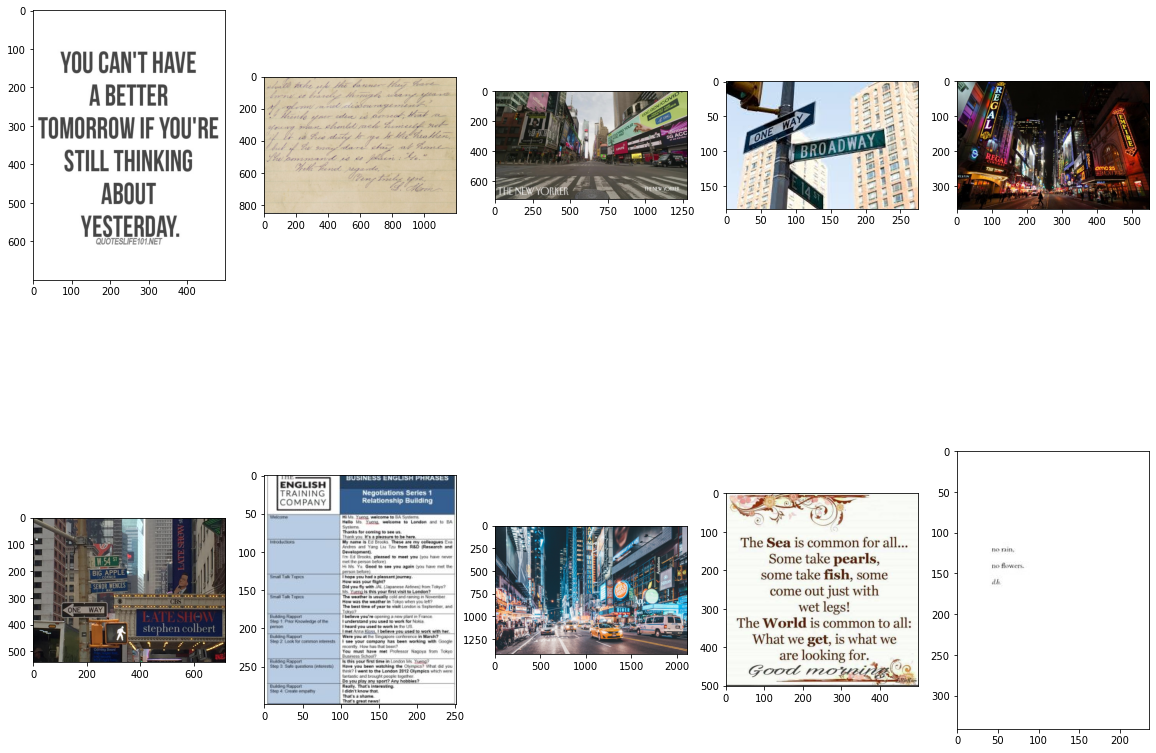

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img_list=[]
plt.figure(figsize=(20,15))



for i in range(0,10):
    f = data_path + data_path_jpg[i]
    print(f)
    img_list.append(f)
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    b, g, r = cv2.split(img)   # img파일을 b,g,r로 분리
    img2 = cv2.merge([r,g,b]) # b, r을 바꿔서 Merge
    plt.subplot(2,5,i+1)
    plt.imshow(img2)


## 2. keras ocr 적용해보기

In [4]:
import keras_ocr

pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [5]:
keras_images = [keras_ocr.tools.read(img) for img in img_list]

In [6]:
prediction = pipeline.recognize([img_list[0]])

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


<AxesSubplot:>

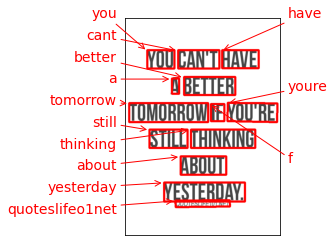

In [7]:
keras_ocr.tools.drawAnnotations(image=keras_images[0], predictions=prediction[0])

In [8]:
prediction_groups = [pipeline.recognize([img]) for img in img_list]

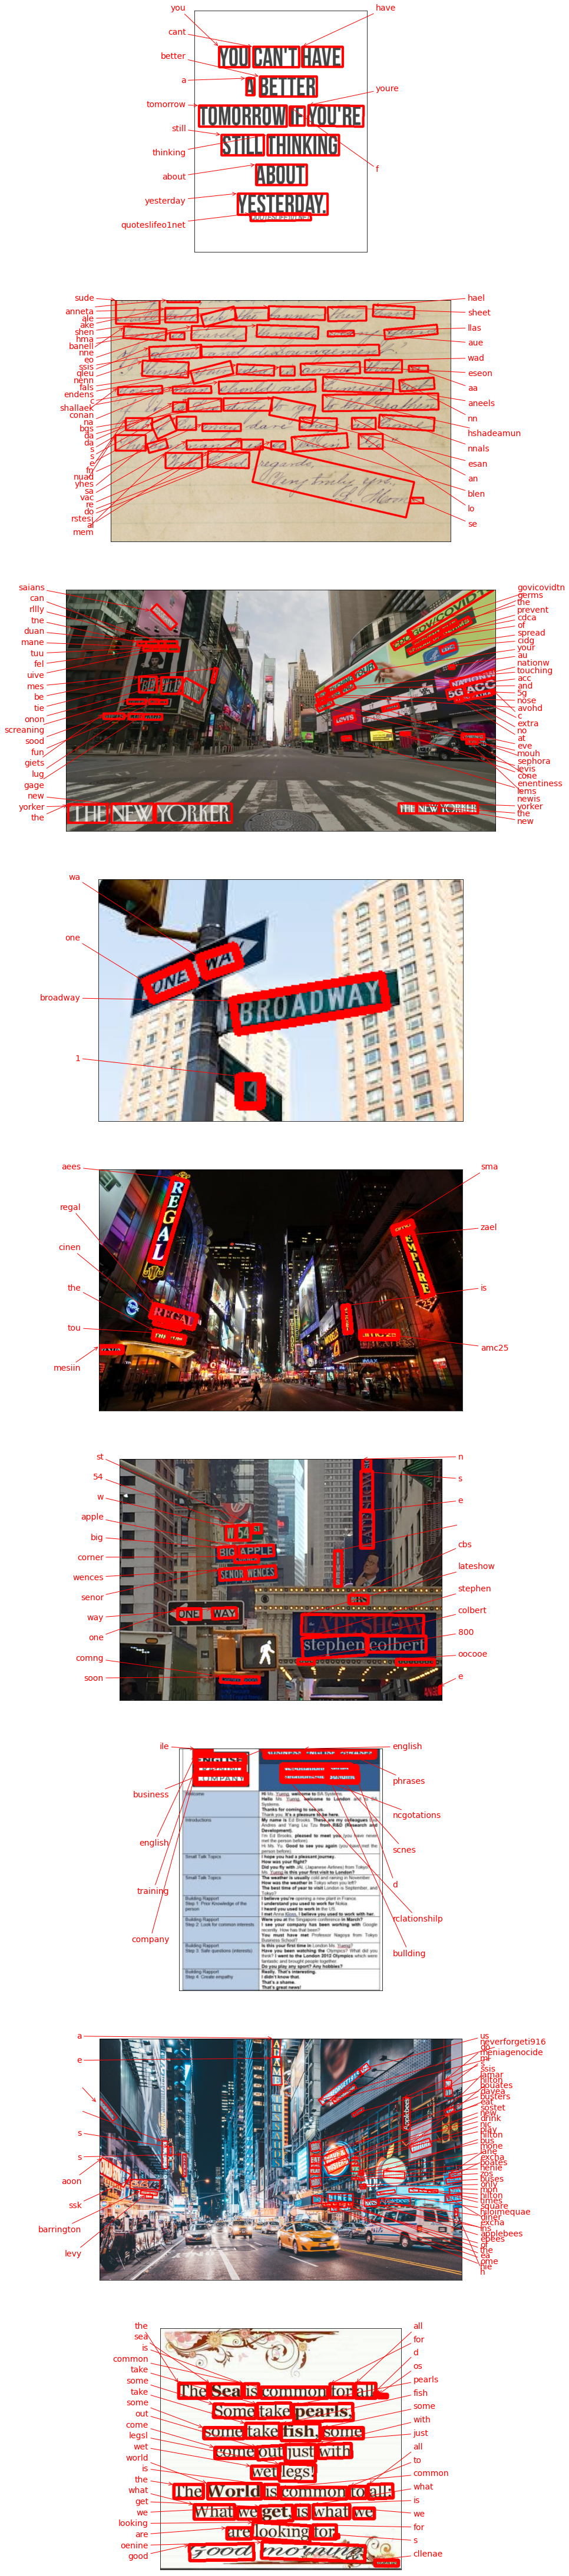

In [9]:
fig, axs = plt.subplots(nrows = 9, figsize = (20, 80))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=keras_images[idx], predictions=prediction_groups[idx][0], ax=ax)

## 결과 해석
* 제가 가져온 이미지의 분류는 3가지 입니다. 길거리사진, 해상도 낮은사진, 글자가 크기가 작고 큰 사진
* keras ocr은 길거리 사진에서 글자가 선명한것만 잘 나오고 나머지는 정확히 인식을 하지는 못했습니다.
* kreas ocr은 글자가 크고 해상도가 좋은 이미지는 잘 인식했습니다.
* keras ocr은 글자가 작고 해상도가 안좋은 이미지는 잘못 인식하거나 인식자체를 하지 못했습니다.

## 2. google OCR 적용해보기

In [10]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [11]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'


for i in range(9):
    print("-"*25+f'image{i}'+"-"*25+'\n\n')
    detect_text(img_list[i])
    

total 756
drwxr-xr-x 8 root root   4096 Dec  1 05:36 crop
drwxr-xr-x 4 root root   4096 Dec  1 05:44 data
-rw-r--r-- 1 root root 763946 Dec  2 01:39 Untitled.ipynb
-------------------------image0-------------------------


Texts:

"YOU CAN'T HAVE
A BETTER
TOMORROW IF YOU'RE
STILL THINKING
ABOUT
YESTERDAY.
QUOTESLIFE101.NET
"

"YOU"

"CAN'T"

"HAVE"

"A"

"BETTER"

"TOMORROW"

"IF"

"YOU'RE"

"STILL"

"THINKING"

"ABOUT"

"YESTERDAY."

"QUOTESLIFE101.NET"
bounds: (163,588),(334,589),(334,609),(163,608)
-------------------------image1-------------------------


Texts:

"Helle hund regande,
whall take uk the banner fhug have
borne e biarely the
omghh sekang yare
glim randdiseouragimient
4
Mhinto your
Mhenk yaur dea i coreo, kuat
rban ehmlel paeh humeulf net
you Pie ddy
bo thtreathine,
thet if lu may dare chary al rane
The ommand is u plhin : ."
Helh hend pegande,
"

"Helle"

"hund"

"regande,"

"whall"

"take"

"uk"

"the"

"banner"

"fhug"

"have"

"borne"

"e"

"biarely"

"the"

"omghh"

Texts:

"The Sea is common for all...
Some take pearls,
some take fish, some
come out just with
wet legs!
The World is common to all:
What we get, is what we
are looking for.
Good moning
"

"The"

"Sea"

"is"

"common"

"for"

"all..."

"Some"

"take"

"pearls,"

"some"

"take"

"fish,"

"some"

"come"

"out"

"just"

"with"

"wet"

"legs!"

"The"

"World"

"is"

"common"

"to"

"all:"

"What"

"we"

"get,"

"is"

"what"

"we"

"are"

"looking"

"for."

"Good"

"moning"
bounds: (201,443),(409,442),(409,484),(201,485)


## 결과 해석
* 제가 가져온 이미지의 분류는 3가지 입니다. 길거리사진, 해상도 낮은사진, 글자가 크기가 작고 큰 사진
* google ocr은 길거리 사진은 keras ocr 보다는 문자 인식을 잘했습니다.
* google ocr은 글자가 크고 해상도가 좋은 이미지는 잘 인식했습니다.
* google ocr은 글자가 작고 해상도가 안좋은 이미지는 keras ocr 보다는 문자 인식을 잘했습니다.

## 3. 테서렉트 OCR 적용해보기

In [12]:

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list




In [14]:
work_dir = os.getenv('HOME')+'/aiffel/ykb/Ex18/data'

img_file_path = work_dir + '/image/letter.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

/aiffel/aiffel/ykb/Ex18/data/0000.png
/aiffel/aiffel/ykb/Ex18/data/0001.png
/aiffel/aiffel/ykb/Ex18/data/0002.png
/aiffel/aiffel/ykb/Ex18/data/0003.png
/aiffel/aiffel/ykb/Ex18/data/0004.png
/aiffel/aiffel/ykb/Ex18/data/0005.png
/aiffel/aiffel/ykb/Ex18/data/0006.png
/aiffel/aiffel/ykb/Ex18/data/0007.png
/aiffel/aiffel/ykb/Ex18/data/0008.png
/aiffel/aiffel/ykb/Ex18/data/0009.png
/aiffel/aiffel/ykb/Ex18/data/0010.png
/aiffel/aiffel/ykb/Ex18/data/0011.png
/aiffel/aiffel/ykb/Ex18/data/0012.png
/aiffel/aiffel/ykb/Ex18/data/0013.png
/aiffel/aiffel/ykb/Ex18/data/0014.png
/aiffel/aiffel/ykb/Ex18/data/0015.png
/aiffel/aiffel/ykb/Ex18/data/0016.png
/aiffel/aiffel/ykb/Ex18/data/0017.png
/aiffel/aiffel/ykb/Ex18/data/0018.png
/aiffel/aiffel/ykb/Ex18/data/0019.png
/aiffel/aiffel/ykb/Ex18/data/0020.png

rae z a

a ae


of

lt

ge

eee

Cree

>


Fs

Z

aie. Roast

a>

Sbu

POPE GPE AP CE

td

fe0



Done


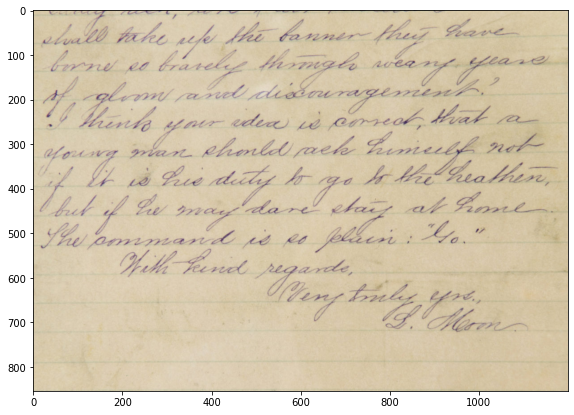

In [15]:
plt.figure(figsize=(10, 7))
img=cv2.imread(img_list[1], cv2.COLOR_BGR2RGB)
b, g, r = cv2.split(img)   # img파일을 b,g,r로 분리
img2 = cv2.merge([r,g,b]) # b, r을 바꿔서 Merge
plt.imshow(img2)

In [16]:
work_dir = os.getenv('HOME')+'/aiffel/ykb/Ex18/data'

img_file_path = work_dir + '/image/plat1.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

/aiffel/aiffel/ykb/Ex18/data/0000.png
/aiffel/aiffel/ykb/Ex18/data/0001.png
/aiffel/aiffel/ykb/Ex18/data/0002.png
/aiffel/aiffel/ykb/Ex18/data/0003.png
/aiffel/aiffel/ykb/Ex18/data/0004.png
/aiffel/aiffel/ykb/Ex18/data/0005.png
/aiffel/aiffel/ykb/Ex18/data/0006.png
/aiffel/aiffel/ykb/Ex18/data/0007.png
/aiffel/aiffel/ykb/Ex18/data/0008.png
/aiffel/aiffel/ykb/Ex18/data/0009.png
/aiffel/aiffel/ykb/Ex18/data/0010.png
/aiffel/aiffel/ykb/Ex18/data/0011.png
VOU

CAN'T

HAVE

A BETTER

TOMORROW

F

YOU'RE

STILL

THINKING

ABOUT

VESTERDAY.

QUOTESLIFET01.NET

Done


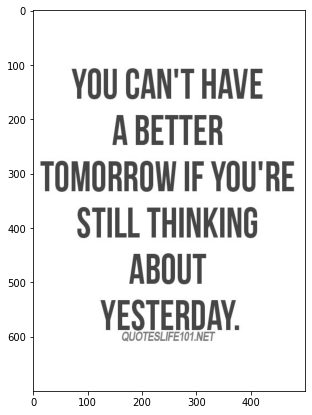

In [17]:
plt.figure(figsize=(10, 7))
img=cv2.imread(img_list[0], cv2.COLOR_BGR2RGB)
b, g, r = cv2.split(img)   # img파일을 b,g,r로 분리
img2 = cv2.merge([r,g,b]) # b, r을 바꿔서 Merge
plt.imshow(img2)

In [18]:
work_dir = os.getenv('HOME')+'/aiffel/ykb/Ex18/data'

img_file_path = work_dir + '/image/plat2.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

/aiffel/aiffel/ykb/Ex18/data/0000.png
/aiffel/aiffel/ykb/Ex18/data/0001.png
/aiffel/aiffel/ykb/Ex18/data/0002.png
/aiffel/aiffel/ykb/Ex18/data/0003.png
/aiffel/aiffel/ykb/Ex18/data/0004.png
/aiffel/aiffel/ykb/Ex18/data/0005.png
/aiffel/aiffel/ykb/Ex18/data/0006.png
/aiffel/aiffel/ykb/Ex18/data/0007.png
/aiffel/aiffel/ykb/Ex18/data/0008.png
/aiffel/aiffel/ykb/Ex18/data/0009.png
/aiffel/aiffel/ykb/Ex18/data/0010.png
/aiffel/aiffel/ykb/Ex18/data/0011.png
/aiffel/aiffel/ykb/Ex18/data/0012.png
/aiffel/aiffel/ykb/Ex18/data/0013.png
/aiffel/aiffel/ykb/Ex18/data/0014.png
/aiffel/aiffel/ykb/Ex18/data/0015.png
/aiffel/aiffel/ykb/Ex18/data/0016.png
/aiffel/aiffel/ykb/Ex18/data/0017.png
/aiffel/aiffel/ykb/Ex18/data/0018.png
/aiffel/aiffel/ykb/Ex18/data/0019.png
/aiffel/aiffel/ykb/Ex18/data/0020.png
/aiffel/aiffel/ykb/Ex18/data/0021.png
/aiffel/aiffel/ykb/Ex18/data/0022.png
/aiffel/aiffel/ykb/Ex18/data/0023.png
/aiffel/aiffel/ykb/Ex18/data/0024.png
/aiffel/aiffel/ykb/Ex18/data/0025.png
/aiffel/aiff

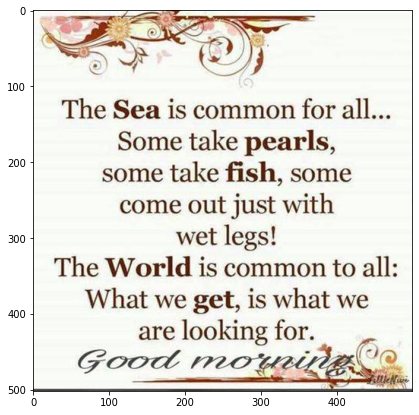

In [19]:
plt.figure(figsize=(10, 7))
img=cv2.imread(img_list[8], cv2.COLOR_BGR2RGB)
b, g, r = cv2.split(img)   # img파일을 b,g,r로 분리
img2 = cv2.merge([r,g,b]) # b, r을 바꿔서 Merge
plt.imshow(img2)

In [20]:
work_dir = os.getenv('HOME')+'/aiffel/ykb/Ex18/data'

img_file_path = work_dir + '/image/small2.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

/aiffel/aiffel/ykb/Ex18/data/0000.png
ih

Done


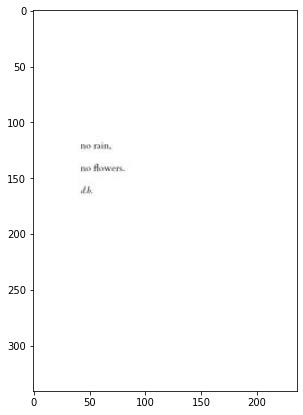

In [21]:
plt.figure(figsize=(10, 7))
img=cv2.imread(img_list[9], cv2.COLOR_BGR2RGB)
b, g, r = cv2.split(img)   # img파일을 b,g,r로 분리
img2 = cv2.merge([r,g,b]) # b, r을 바꿔서 Merge
plt.imshow(img2)

In [22]:
work_dir = os.getenv('HOME')+'/aiffel/ykb/Ex18/data'

img_file_path = work_dir + '/image/small.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

/aiffel/aiffel/ykb/Ex18/data/0000.png
/aiffel/aiffel/ykb/Ex18/data/0001.png
/aiffel/aiffel/ykb/Ex18/data/0002.png
/aiffel/aiffel/ykb/Ex18/data/0003.png
/aiffel/aiffel/ykb/Ex18/data/0004.png
/aiffel/aiffel/ykb/Ex18/data/0005.png
Negotiations Series 1

pi belelth lalisMe lillie lale





Done


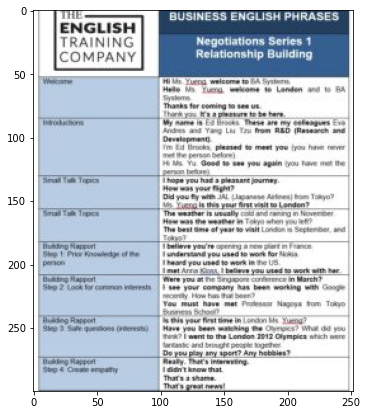

In [23]:
plt.figure(figsize=(10, 7))
img=cv2.imread(img_list[6], cv2.COLOR_BGR2RGB)
b, g, r = cv2.split(img)   # img파일을 b,g,r로 분리
img2 = cv2.merge([r,g,b]) # b, r을 바꿔서 Merge
plt.imshow(img2)

## 결과 해석
* 제가 가져온 이미지의 분류는 3가지 입니다. 길거리사진, 해상도 낮은사진, 글자가 크기가 작고 큰 사진
* 테서렉트 ocr은 글자크기가 크고 해상도가 좋은 이미지는 문자인식은 잘했습니다. 
* 테서렉트 ocr은 글씨가 작고 해상도가 낮은 이미지는 문자인식을 거의 하지못했습니다.
* 테서렉트 ocr은 길거리 사진은 문자를 아예 인식도 못해 분할도 안되었습니다.

## 회고

* 3가지 모델을 비교했을 때 구글 ocr이 가장 좋은 성능을 보이고 그다음 keras, 테서렉트 순으로 성능을 보였습니다. 구글 모델은 영어문자를 인식할때 대소문자도 인식이 되는것을 보여 인상깊었고 영어 문자를 인식할 경우가 있으면 구글 ocr을 사용하는것이 좋아보입니다